# Cleaning Functions for the Injury, Playlist, and Tracking data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

In [2]:
playlist = pd.read_csv("NFL_Turf/PlayList.csv")
injuries = pd.read_csv("NFL_Turf/InjuryRecord.csv")

(array([ 5654., 65790., 61181., 15522.,     0.,     0.,  3813., 15763.,
        52168., 47114.]),
 array([-62. ,  -7.8,  46.4, 100.6, 154.8, 209. , 263.2, 317.4, 371.6,
        425.8, 480. ]),
 <BarContainer object of 10 artists>)

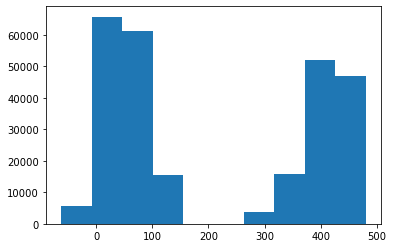

In [3]:
plt.hist(playlist.PlayerDay)

PlayerDay is supposed to represent the number of days that the player has been playing. This dataset covers 2 seasons of play, but instead of resetting the number of days between seasons, the beginning of the second season just continued to count from the first day of play, which was -62. This will be corrected for, making each season start, day 1.

In [4]:
min(playlist.PlayerDay)

-62

In [5]:
min(playlist.PlayerDay[playlist.PlayerDay > 200])

274

- The first game of the first season starts at PlayerDay = -62, add 63 to any game under 300 games
- The first game of the second season starts at PlayerDay = 274, so 273 will be subtracted from any game over 200 games

In [6]:
playlist['DaysPlayed'] = playlist['PlayerDay'].apply(lambda x: x + 63 if x < 200 else x - 273)
playlist.head()


,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,DaysPlayed
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB,64
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB,64
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB,64
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB,64
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB,64


In [7]:
min(playlist.DaysPlayed)

1

In [8]:
max(playlist.DaysPlayed)

207

In [9]:
max(playlist.PlayerDay) - 273

207

## Cleaning Playlist Data

***Analyzing the Plays from the PlayList file***

- The first thing to note is that this list contains all of the plays, including the exact play that will match with the injury list, therefore anything that is on both with the exception of the PlayerKey should be maintained on THIS DF so that we don't lose data on the non-injury columns
- In order to separate the files to do predictive analysis on ONLY the injuries, there will be two output files, one with an outer merge that maintains the non-injuty data and one with an inner merge that only keeps data associated with injury
- PlayKey will be used as the Key to merge the datasets, so PlayerKey and GameID can be removed. While FieldType information is also in the surface column of the injuries table, we need to maintain it here, so we don't lose the data from the columns not containing injuries. 

### The Dataset

- PlayKeys represent all plays, not only those where injuries occurred - these will function to merge the tables
- FieldType only has 2 values, Natural or Synthetic and can be easily changed to binary values 
- Stadium Type is also strange with 29 unique types of stadiums. These will be grouped as either Outdoor, or Indoor
- Games played in retractable roof stadiums with Open Domes are Outdoor, Closed Domes are Indoor
- Weather - there are 63 unique types of weather.... this is odd
- RosterPosition, Position, and Position Group are all similar and need to be investigated
- PlayTypes should be encoded, as they are categorical such as pass, rush, kick, ... 

### Encoding the Data

- Binary Encoding can happen for FieldType and StadiumType
- For positions, plays, and weather, need to consider whether it is better to use dummies/OneHotEncoder or use numerical values in a single column

In [10]:
playlist.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,DaysPlayed
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB,64
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB,64
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB,64
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB,64
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB,64


## Transformation Functions

### Playlist Functions

1. Surface_Coder - takes the Dataframe input and creates a new column in the df called SyntheticField with a 1 for True and 0 for false, or Natural Field
2. Stadium_Coder - takes the DF and replaces the StadiumTypes from having 29 stadium types to 2, either Indoor or Outdoor. Also creates a new numerical column called 'Outdoor' with binary values where 1 is True (Outdoor) and 0 is false (Indoor)
3. Temperature_Adjuster - takes rows from df where the temperature was recorded as -999 degrees. For all stadiums that are indoor, this temperature is set to 70 degrees. The others are removed from the dataframe
4. Weather_Coder - creates categories and groups the 63 weather types into 7 (Indoor, Clear, Cloudy, Windy, Hazy/Fog, Rain, Snow). Also creates a new column called 'precipitation' where 1 is True and denotes that there was rain or snow, and 0 that there was not. 
5. Position_Coder - This changes the positions from string to numeric using a full list of NFL positions to accommodate for any future injuries or players in the data. This applies to both the RosterPosition column and the Positions column
6. PlayerDay_Adjuster - The minimum playerday was -62, which causes problems in some of the analysis expecting all positive numbers. This function simply adds 63 days to all players. Additionally, since the seasons were stacked by days, for any day over 200, the number will be reduced by 274, so that day 1 is always the first game of the season
7. Play_Coder - Changes all plays involving the special player for kicking plays to 'Kick', so now there are only 3 categories for the plays. Also creates a new column called PlayCode with numerical encoding for the 3 play types
8. Process_Playlist_Data - Applies all of the Playlist function to clean and code the Playlist data, outputs cleaned df

### InjuryRecord Functions

1. Injury_Coder - assigns a numerical value to each of the injuries from BodyPart
2. Injury_Duration_Classifier - uses the 4 duration columns to return a list of minimum days injured
3. Injury_Duration_Coder - applies the duration code to create the column as well as to create an additional Severe column, where all injuries over 28 days are considered severe
4. Process_Injury_Data - Applies all of the Injury functions to the clean and code the InjuryRecord data, outputs cleaned df



In [11]:
def Surface_Coder(df):
    # Surface_Coder: Function that encodes the Field Surface to identify natural or synthetic
    surface_map = {
        'Natural': 0,
        'Synthetic': 1
    }

    df['SyntheticField'] = df.FieldType.map(surface_map)

    return df    

In [12]:
def Stadium_Coder(df):
    # Stadium_Coder: This function changes the stadium type to either Outdoor or Indoor, maintaining the categorical label
    df.StadiumType.fillna('Outdoor', inplace=True)
    
    dict = {'Outdoor': 'Outdoor',
        'Indoors': 'Indoor',
        'Oudoor': 'Outdoor',
        'Outdoors': 'Outdoor',
        'Open': 'Outdoor',
        'Closed Dome': 'Indoor',
        'Domed, closed': 'Indoor',
        'Dome': 'Indoor',
        'Indoor': 'Indoor',
        'Domed': 'Indoor',
        'Retr. Roof-Closed': 'Indoor',
        'Outdoor Retr Roof-Open': 'Outdoor',
        'Retractable Roof': 'Indoor',
        'Ourdoor': 'Outdoor',
        'Indoor, Roof Closed': 'Indoor',
        'Retr. Roof - Closed': 'Indoor',
        'Bowl': 'Outdoor',
        'Outddors': 'Outdoor',
        'Retr. Roof-Open': 'Outdoor',
        'Dome, closed': 'Indoor',
        'Indoor, Open Roof': 'Outdoor',
        'Domed, Open': 'Outdoor',
        'Domed, open': 'Outdoor',
        'Heinz Field': 'Outdoor',
        'Cloudy': 'Outdoor',
        'Retr. Roof - Open': 'Outdoor',
        'Retr. Roof Closed': 'Indoor',
        'Outdor': 'Outdoor',
        'Outside': 'Outdoor'}

    df.StadiumType.replace(dict, inplace=True)


    # Create a new column with stadiums coded numerically
    stadium = {
        'Outdoor': 1, 
        'Indoor': 0
    }
    
    # Map the stadiumtype for outdoor as 1 = True and 0 = false
    df['Outdoor'] = df.StadiumType.map(stadium)

    return df

In [13]:
def Temperature_Adjuster(df):
    # Temperature_Adjuster: This function also fixes the -999 temperature issue for all indoor stadiums
    
    # Fix the temperature from -999 at any indoor stadium to 70
    df['Temperature'] = np.where(
        (df['Temperature'] == -999) & (df['StadiumType'] == 'Indoor'), 70, df.Temperature)

    # Extract all values that are not -999 degrees
    df_filtered = df[df['Temperature'] != -999]

    return df_filtered


In [14]:
def Weather_Coder(df):
    # Weather_Coder: This function changes the weather into a smaller subset of categorical groups
    weather_dict = {'Clear and warm': 'Clear',
                    'Mostly Cloudy': 'Cloudy',
                    'Sunny': 'Clear',
                    'Clear': 'Clear',
                    'Cloudy': 'Cloudy',
                    'Cloudy, fog started developing in 2nd quarter': 'Hazy/Fog',
                    'Rain': 'Rain',
                    'Partly Cloudy': 'Cloudy',
                    'Mostly cloudy': 'Cloudy',
                    'Cloudy and cold': 'Cloudy',
                    'Cloudy and Cool': 'Cloudy',
                    'Rain Chance 40%': 'Rain',
                    'Controlled Climate': 'Indoor',
                    'Sunny and warm': 'Clear',
                    'Partly cloudy': 'Cloudy',
                    'Clear and Cool': 'Cloudy',
                    'Clear and cold': 'Cloudy',
                    'Sunny and cold': 'Clear',
                    'Indoor': 'Indoor',
                    'Partly Sunny': 'Clear',
                    'N/A (Indoors)': 'Indoor',
                    'Mostly Sunny': 'Clear',
                    'Indoors': 'Indoor',
                    'Clear Skies': 'Clear',
                    'Partly sunny': 'Clear',
                    'Showers': 'Rain',
                    'N/A Indoor': 'Indoor',
                    'Sunny and clear': 'Clear',
                    'Snow': 'Snow',
                    'Scattered Showers': 'Rain',
                    'Party Cloudy': 'Cloudy',
                    'Clear skies': 'Clear',
                    'Rain likely, temps in low 40s.': 'Rain',
                    'Hazy': 'Hazy/Fog',
                    'Partly Clouidy': 'Cloudy',
                    'Sunny Skies': 'Clear',
                    'Overcast': 'Cloudy',
                    'Cloudy, 50% change of rain': 'Cloudy',
                    'Fair': 'Clear',
                    'Light Rain': 'Rain',
                    'Partly clear': 'Clear',
                    'Mostly Coudy': 'Cloudy',
                    '10% Chance of Rain': 'Cloudy',
                    'Cloudy, chance of rain': 'Cloudy',
                    'Heat Index 95': 'Clear',
                    'Sunny, highs to upper 80s': 'Clear',
                    'Sun & clouds': 'Cloudy',
                    'Heavy lake effect snow': 'Snow',
                    'Mostly sunny': 'Clear',
                    'Cloudy, Rain': 'Rain',
                    'Sunny, Windy': 'Windy',
                    'Mostly Sunny Skies': 'Clear',
                    'Rainy': 'Rain',
                    '30% Chance of Rain': 'Rain',
                    'Cloudy, light snow accumulating 1-3"': 'Snow',
                    'cloudy': 'Cloudy',
                    'Clear and Sunny': 'Clear',
                    'Coudy': 'Cloudy',
                    'Clear and sunny': 'Clear',
                    'Clear to Partly Cloudy': 'Clear',
                    'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.': 'Windy',
                    'Rain shower': 'Rain',
                    'Cold': 'Clear'}


    df.Weather.replace(weather_dict, inplace=True)

    # There are still na values within the weather group that need to be addressed
    df.loc[df.StadiumType == 'Indoor', 'Weather'] = df.loc[df.StadiumType == 'Indoor', 'Weather'].fillna('Indoor')

    # Because we can't make a determination on the type of weather for outdoor, drop the remaining na values
    df = df.loc[df.Weather.isna() == False]


       
    return df

In [15]:
def Precipitation_Coder(df):
    # Add a column for the presence of precipitation, that will ultimately be used for numerical analysis of the weather.
    precipitation = {
        'Indoor': 0,
        'Clear': 0,
        'Cloudy': 0,
        'Windy': 0,
        'Hazy/Fog': 0,
        'Rain': 1,
        'Snow': 1
    }

    df['Precipitation'] = df.Weather.map(precipitation)
    return df

In [16]:
def ML_Position_Coder(df): 
    # ML_Position_Coder: This function encodes the players by position and rosterposition
    df['Position'] = np.where(df['Position'] == 'Missing Data', df['RosterPosition'], df['Position'])

    position = {
        'Quarterback': 0,
        'QB': 0,
        'Running Back': 1,
        'RB': 1,
        'FB': 2, 
        'Wide Receiver': 3,
        'WR': 3,
        'Tight End': 4,
        'TE': 4,
        'Offensive Lineman': 5,
        'OL': 5,
        'C': 6,
        'G': 7,
        'LG': 8,
        'RG': 9, 
        'T': 10, 
        'LT': 11, 
        'RT': 12, 
        'Kicker': 13,
        'K': 13,
        'KR': 14, 
        'Defensive Lineman': 15,
        'DL': 15,
        'DE': 16,
        'DT': 17, 
        'NT': 18, 
        'Linebacker': 19,
        'LB': 19,
        'OLB': 20,
        'ILB': 21,
        'MLB': 22,
        'DB': 23,
        'Cornerback': 24,
        'CB': 24,
        'Safety': 25,
        'S': 25,
        'SS': 26,
        'FS': 27,
        'P': 28,
        'PR': 29, 
        'HB': 30
    }

    df.RosterPosition.replace(position, inplace=True)
    df.Position.replace(position, inplace=True)
    df.Position.astype(int)
    df.drop(columns='PositionGroup', inplace=True)

    return df

In [17]:
def Vis_Position_Coder(df):
    # Vis_Position_Coder: This function replaces nan position with rosterposition and drops the position group column
    df['Position'] = np.where(df['Position'] == 'Missing Data', df['RosterPosition'], df['Position'])
    
    position = {
        'Quarterback': 'QB',
        'Running Back': 'RB',
        'Wide Receiver': 'WR',
        'Tight End': 'TE',
        'Offensive Lineman': 'OL',
        'Kicker': 'K',
        'Defensive Lineman': 'DL',
        'Linebacker': 'LB',
        'Cornerback': 'CB',
        'Safety': 'S'
         }
    
    df.Position.replace(position, inplace=True)
    df.drop(columns='PositionGroup', inplace=True)
    return df

In [18]:
def PlayerDay_Adjuster(df):
    # PlayerDay_Adjuster: This function adjusts the player day to remove the negative values
    df['DaysPlayed'] = df['PlayerDay'].apply(lambda x: x + 63 if x < 200 else x - 273)

    df.drop(columns='PlayerDay', inplace=True)

    return df

In [19]:
def Play_Coder(df):
    # Play_Coder: This function creates a categorical grouping for the different types of plays, grouping into passing, rushing, or kicking plays

    play_type = {
        'Pass': 'Pass',
        'Rush': 'Rush',
        'Extra Point': 'Kick',
        'Kickoff': 'Kick',
        'Punt': 'Kick',
        'Field Goal': 'Kick',
        'Kickoff Not Returned': 'Kick',
        'Punt Not Returned': 'Kick',
        'Kickoff Returned': 'Kick',
        'Punt Returned': 'Kick',
        '0': 'Kick'
    }

    play_map = {
        'Pass': 0, 
        'Rush': 1, 
        'Kick': 2
    }

    df.PlayType.replace(play_type, inplace=True)
    df['PlayCode'] = df.PlayType.map(play_map)

    df = df.loc[df.PlayType.isna() == False]
    df.PlayCode.astype(int)

    return df

In [52]:
def ML_Process_Playlist_Data(df):
    # ML_Process_Playlist_Data: Create cleaning function to apply all of the other functions to the single df input for Machine Learning
    df = Surface_Coder(df)
    df = Stadium_Coder(df)
    df = Temperature_Adjuster(df)
    df = Weather_Coder(df)
    df = Precipitation_Coder(df)
    df = ML_Position_Coder(df)
    df = PlayerDay_Adjuster(df)
    df = Play_Coder(df)

    df.drop(columns=['PlayerKey', 'GameID', 'PlayerGame', 'StadiumType',
            'FieldType', 'Weather', 'PlayType'], inplace=True)
    return df

In [54]:
def Vis_Process_Playlist_Data(df):
    # Vis_Process_Playlist_Data: Create cleaning function to apply all of the other functions to the single df input for visualizations

    df = Stadium_Coder(df)
    df = Temperature_Adjuster(df)
    df = Weather_Coder(df)
    df = Vis_Position_Coder(df)
    df = PlayerDay_Adjuster(df)
    df = Play_Coder(df)

    df.drop(columns=['PlayerKey', 'GameID', 'PlayerGame', 'Outdoor', 'PlayCode'], inplace=True)
    return df

## Cleaning Injury List Data

- Depending on the Join, there will be groupings with NoInjury, which needs to be coded as well as the others
- The DM_M# columns represent the minimum number of days that the player was out - this can be turned into a continuous data type
- Can also create a binary output for Severe, over 28 days, and Less Severe for under
- There are some playKeys that are NAN and need to be removed, since there is no indication when or how the injury occurred
- Surface can be removed, since this will be merged with the other table that already contains this information

In [22]:
def Injury_Coder(df):
    # Injury_Coder: This function codifies the injury types based on their frequency of occurrence, adding this as a new column called "InjuryType"

    knee_freq = df.BodyPart.value_counts()['Knee']
    ankle_freq = df.BodyPart.value_counts()['Ankle']
    foot_freq = df.BodyPart.value_counts()['Foot']
        
    injury_map = {
        'NoInjury': 0, 
        'Foot': foot_freq, 
        'Ankle': ankle_freq, 
        'Knee': knee_freq
    }

    df['InjuryType'] = df.BodyPart.map(injury_map)

    # Remove any injuries not associated with a play
    df = df.loc[df.PlayKey.isna() == False]
    
    return df

In [23]:
def Injury_Duration_Classifier(row):
    # Injury_Duration_Classifier: This creates a new list of numerical values as the shortest number of days of injury

    injury_duration = 0
    if row["DM_M42"] == 1:
        injury_duration = 42
    else:
        if row["DM_M28"] == 1:
            injury_duration = 28
        else:
            if row["DM_M7"] == 1:
                injury_duration = 7
            else: 
                injury_duration = 1
    

    return injury_duration

In [24]:
def Injury_Duration_Coder(df): 
    # Injury_Duration_Coder: Apply the Injury Duration Classifier to the dataframe

    df['InjuryDuration'] = df.apply(Injury_Duration_Classifier, axis=1)

    severity_map = {
        42: 1, 
        28: 1,
        7: 0, 
        1: 0 
    }
    df['SevereInjury'] = df.InjuryDuration.map(severity_map)
    df.InjuryDuration.astype(int)
    df.SevereInjury.astype(int)

    return df

In [25]:
def ML_Process_Injury_Data(df): 
    # ML_Process_Injury_Data: This function applies all of the InjuryRecord table processing Functions

    df = Injury_Coder(df)
    df = Injury_Duration_Coder(df)

    # Drop any PlayKey NaN values
    df = df.loc[df.PlayKey.isna() == False]    


    # Drop the columns that are redundant with those from the Playlist Dataframe inpreparation for the Merge.
    df.drop(columns=['GameID',
                       'PlayerKey',
                       'Surface',
                       'BodyPart',
                       'DM_M1',
                       'DM_M7',
                       'DM_M28',
                       'DM_M42'], inplace=True)


    return df

In [26]:
def Vis_Process_Injury_Data(df):
    # Process_Injury_Data: This function applies all of the InjuryRecord table processing Functions

    df = Injury_Coder(df)
    df = Injury_Duration_Coder(df)

    # Drop any PlayKey NaN values
    df.PlayKey.dropna(inplace=True)

    # Drop the columns that are redundant with those from the Playlist Dataframe inpreparation for the Merge.
    df.drop(columns=['GameID',
                     'PlayerKey',
                     'InjuryType',
                     'Surface',
                     'DM_M1',
                     'DM_M7',
                     'DM_M28',
                     'DM_M42'], inplace=True)

    return df

## Merge the PlayList and Injury Dataframes

The next line creates two merges:
- The outer merge that will include all data, not only the data associated with injuries
- The outer merge data may be better suited to only looking at the final play position from the tracking data
- The inner merge will only include data associated with the injuries
- The inner merge won't produce many unique plays, but when merged with the tracking data, this df will get exponentially larger, giving better predictability with injury type classification


In [59]:
def ML_Data_Cleaner(playlist, injuries):
    # This is the overall function that cleans and merges the data for Machine Learning data processing

    playlist = ML_Process_Playlist_Data(playlist)
    injuries = ML_Process_Injury_Data(injuries)
    
    ML_outer = pd.merge(playlist, injuries, on='PlayKey', how='outer')
    
    ML_outer.InjuryType.fillna(0, inplace=True)
    ML_outer.InjuryDuration.fillna(0, inplace=True)
    ML_outer.SevereInjury.fillna(0, inplace=True)

    return ML_outer

In [60]:
playlist = pd.read_csv("NFL_Turf/PlayList.csv")
injuries = pd.read_csv("NFL_Turf/InjuryRecord.csv")

ML_outer = ML_Data_Cleaner(playlist, injuries)

In [92]:
injuries.BodyPart.value_counts()

Knee     48
Ankle    42
Foot      7
Toes      7
Heel      1
Name: BodyPart, dtype: int64

Verify that all output values are numeric before exporting the table

In [61]:
ML_outer.dtypes

PlayKey            object
RosterPosition      int64
Temperature         int64
PlayerGamePlay      int64
Position            int64
SyntheticField      int64
Outdoor             int64
Precipitation       int64
DaysPlayed          int64
PlayCode          float64
InjuryType        float64
InjuryDuration    float64
SevereInjury      float64
dtype: object

In [62]:
def Vis_Data_Cleaner(playlist, injuries):
    # This is the overall function for cleaning and merging the data for Visualizations 

    playlist = Vis_Process_Playlist_Data(playlist)
    injuries = Vis_Process_Injury_Data(injuries)

    Vis_outer = pd.merge(playlist, injuries, on='PlayKey', how='outer')

    Vis_outer.BodyPart.fillna("NoInjury", inplace=True)
    Vis_outer.InjuryDuration.fillna(0, inplace=True)
    Vis_outer.SevereInjury.fillna(0, inplace=True)

    return Vis_outer

In [63]:
playlist = pd.read_csv("NFL_Turf/PlayList.csv")
injuries = pd.read_csv("NFL_Turf/InjuryRecord.csv")

Vis_outer = Vis_Data_Cleaner(playlist, injuries)

In [64]:
Vis_outer.head()

,PlayKey,RosterPosition,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,DaysPlayed,BodyPart,InjuryDuration,SevereInjury
0,26624-1-1,Quarterback,Outdoor,Synthetic,63,Clear,Pass,1,QB,64,NoInjury,0.0,0.0
1,26624-1-2,Quarterback,Outdoor,Synthetic,63,Clear,Pass,2,QB,64,NoInjury,0.0,0.0
2,26624-1-3,Quarterback,Outdoor,Synthetic,63,Clear,Rush,3,QB,64,NoInjury,0.0,0.0
3,26624-1-4,Quarterback,Outdoor,Synthetic,63,Clear,Rush,4,QB,64,NoInjury,0.0,0.0
4,26624-1-5,Quarterback,Outdoor,Synthetic,63,Clear,Pass,5,QB,64,NoInjury,0.0,0.0


## Tracking Data Cleaner

In [33]:
tracking = pd.read_csv('NFL_Turf/PlayerTrackData.csv')
tracking.head()

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09


The tracking data measures the movement every 1/10 second, giving us an exorbitant amount of data that can be applied differently, depending on the purpose of the analysis. 

- For the Outer Merged Data including all non-injury data, it may be beneficial to only look at the last time and position of each play. 
- For the Inner Merged Data only including the injuries, it may be more beneficial to look at each full play.  
- The first play in the table alone has 298 rows in the single 29.8 second play
- There isn't really anything to clean in this table, but it will be problematic to add all of the additional columns to 76 million rows

## Adding Injuries to Tracking Data


In [34]:
print(tracking.PlayKey.nunique() - playlist.PlayKey.nunique())

-45


There seem to be about 45 plays in the tracking that do not exist in the Playlist, so these will be dropped.

In [65]:
# Create a new df that is a subset of PlayKeys and Injuries both Categorical and Numerical
injury_columns = Vis_outer.loc[:,['PlayKey', 'BodyPart']]
injury_columns = Injury_Coder(injury_columns)
injury_columns.head()

,PlayKey,BodyPart,InjuryType
0,26624-1-1,NoInjury,0
1,26624-1-2,NoInjury,0
2,26624-1-3,NoInjury,0
3,26624-1-4,NoInjury,0
4,26624-1-5,NoInjury,0


In [66]:
track_outer = pd.merge(tracking, injury_columns, on='PlayKey', how='outer')

In [67]:
track_outer.head()

,PlayKey,time,event,x,y,dir,dis,o,s,BodyPart,InjuryType
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13,NoInjury,0.0
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12,NoInjury,0.0
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12,NoInjury,0.0
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10,NoInjury,0.0
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09,NoInjury,0.0


In [68]:
track_outer.shape

(76367083, 11)

We needed to remove all of the plays from the play key that aren't associated to the other lists, since we can't even say that they were 'noinjury' plays

So this took 5.25 minutes to save as a csv, which I don't intend to upload or deal with until it's been cut down a bit

In [69]:
track_outer = track_outer.loc[track_outer.BodyPart.isna() == False, :]
track_outer.shape

(74498955, 11)

If we're going to do an unsupervised analysis on the big dataset, we'll need to use AWS and Colab, since a local machine doesn't have enough memory to open the csv, let alone run machine learning models on this

In [70]:
# track_outer.to_csv('Merged_Tables/tracking_all.csv', index=False)

In [71]:
injury_plays = track_outer.loc[track_outer.BodyPart != "NoInjury", :]

In [72]:
injury_plays.head()

,PlayKey,time,event,x,y,dir,dis,o,s,BodyPart,InjuryType
2085848,31070-3-7,0.0,line_set,44.07,32.14,23.31,0.0,174.83,0.03,Knee,36.0
2085849,31070-3-7,0.1,NaN,44.08,32.14,20.18,0.0,175.09,0.03,Knee,36.0
2085850,31070-3-7,0.2,NaN,44.08,32.14,16.53,0.0,175.35,0.03,Knee,36.0
2085851,31070-3-7,0.3,NaN,44.08,32.14,13.23,0.0,175.60,0.02,Knee,36.0
2085852,31070-3-7,0.4,NaN,44.08,32.14,9.78,0.0,175.82,0.02,Knee,36.0


## Merge the Injury Plays with the Tracking Data

### Merge the Machine Learning Data in preparation for export

In [73]:
Pre_injury_plays = injury_plays.drop(columns=["BodyPart", "InjuryType", 'event'])
ML_injury_tracking = pd.merge(Pre_injury_plays, ML_outer, on='PlayKey', how='outer')
ML_injury_tracking.head()

,PlayKey,time,x,y,dir,dis,o,s,RosterPosition,Temperature,PlayerGamePlay,Position,SyntheticField,Outdoor,Precipitation,DaysPlayed,PlayCode,InjuryType,InjuryDuration,SevereInjury
0,31070-3-7,0.0,44.07,32.14,23.31,0.0,174.83,0.03,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0
1,31070-3-7,0.1,44.08,32.14,20.18,0.0,175.09,0.03,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0
2,31070-3-7,0.2,44.08,32.14,16.53,0.0,175.35,0.03,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0
3,31070-3-7,0.3,44.08,32.14,13.23,0.0,175.60,0.02,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0
4,31070-3-7,0.4,44.08,32.14,9.78,0.0,175.82,0.02,1,89,7,1,0,1,0,78,1.0,48.0,42.0,1.0


In [74]:
ML_injury_tracking.dtypes

PlayKey            object
time              float64
x                 float64
y                 float64
dir               float64
dis               float64
o                 float64
s                 float64
RosterPosition      int64
Temperature         int64
PlayerGamePlay      int64
Position            int64
SyntheticField      int64
Outdoor             int64
Precipitation       int64
DaysPlayed          int64
PlayCode          float64
InjuryType        float64
InjuryDuration    float64
SevereInjury      float64
dtype: object

In [75]:
ML_injury_tracking.shape

(283428, 20)

In [76]:
ML_injury_tracking = ML_injury_tracking.loc[ML_injury_tracking.time.isna() == False]
ML_injury_tracking.shape

(22775, 20)

Export the machine learning merged data to csv

In [78]:
ML_injury_tracking.to_csv("Shared_Tables/ml_injury_tracking.csv", index=False)

### Merge the Visual Injury and Tracking in preparation for Export

In [85]:
Pre_injury_plays = injury_plays.drop(columns=["BodyPart", "InjuryType"])
Vis_injury_tracking = pd.merge(Pre_injury_plays, Vis_outer, on='PlayKey', how='outer')
Vis_injury_tracking.head()

,PlayKey,time,event,x,y,dir,dis,o,s,RosterPosition,...,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,DaysPlayed,BodyPart,InjuryDuration,SevereInjury
0,31070-3-7,0.0,line_set,44.07,32.14,23.31,0.0,174.83,0.03,Running Back,...,Natural,89,Clear,Rush,7,RB,78,Knee,42.0,1.0
1,31070-3-7,0.1,NaN,44.08,32.14,20.18,0.0,175.09,0.03,Running Back,...,Natural,89,Clear,Rush,7,RB,78,Knee,42.0,1.0
2,31070-3-7,0.2,NaN,44.08,32.14,16.53,0.0,175.35,0.03,Running Back,...,Natural,89,Clear,Rush,7,RB,78,Knee,42.0,1.0
3,31070-3-7,0.3,NaN,44.08,32.14,13.23,0.0,175.60,0.02,Running Back,...,Natural,89,Clear,Rush,7,RB,78,Knee,42.0,1.0
4,31070-3-7,0.4,NaN,44.08,32.14,9.78,0.0,175.82,0.02,Running Back,...,Natural,89,Clear,Rush,7,RB,78,Knee,42.0,1.0


In [86]:
Vis_injury_tracking.shape

(283428, 21)

In [87]:
Vis_injury_tracking = Vis_injury_tracking.loc[Vis_injury_tracking.time.isna() == False]
Vis_injury_tracking.shape


(22775, 21)

In [88]:
Vis_injury_tracking.to_csv("Shared_Tables/vis_injury_tracking.csv", index=False)

In [90]:
Vis_injury_tracking.BodyPart.value_counts()

Knee     10827
Ankle    10225
Foot      1723
Name: BodyPart, dtype: int64